## Creating a GIF of water level change at Lake Cachuma

### About

Lake Cachuma was once a primary water source for Santa Barbara County, but the California drought has made it an unreliable resevoir. In 2017, the reservoir was part of the 2.13% of California that was considered to be in an "exceptional drought". Given that this resevoir is the majority water source for over 200,000 Santa Barbara residents, the water levels in the Cachuma have a major impact on its residents. While the drought is not over, heavy rains in 2022 - 2023 helped Lake Cachuma reach it's capacity for the first time in 11 years. 


![](images/lake_cachuma_levels.jpeg)


### Purpose

We will use satelittle imagery to see if we can notice changes in water levels when the reservoir was at an all time low versus the following years. We will be specifically looking at the water levels in Harvey Bay. In order to show the water level change in this 6 year time span, we will create a GIF. 

![](images/lake_cachuma_map.png)

### About the data:

To carry out this task, we will use the Microsoft Planetary Computer Catalog. We will be using NAIP imagery from the catalog in the years 2016 to 2022.  

#### Load libraries and data

First, lets load our libraries. To create the GIF we’ll be using the [geogif](https://geogif.readthedocs.io/en/latest/) library, which makes it simple to create GIFs from `xarray.DataArrays`.

In [1]:
import pandas as pd
import geopandas as gpd

import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 

from geogif import gif   # To create the GIF
from IPython.display import Image 

Next we will access our data via the MPC catalog. Access the NAIP collection and store the collection in `naip_collection`.

In [2]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)


catalog.get_collections()
collections = list(catalog.get_collections()) # Turn generator into list

# Print the number of collections
print('Number of collections:', len(collections))

# Pull out the NAIP collection
naip_collection = catalog.get_child('naip')
naip_collection

Number of collections: 126


<CollectionClient id=naip>

Now that we have our data, we need to specify the temporal and spatial information we are interested in. Specify the range of interest in the `time_range` variable. We are intersted at the time when Lake Cachuma was at its lowest (01/01/2016) until the heavy rain storms (01/01/2023). 

In [3]:
# Temporal range of interest during drought
dates = "2016-01-01/2023-01-01"

The following bounding box coordinates are around Harvey's Cove at lake cachuma.

In [4]:
bbox = [-119.96541203059391,34.57264927127669 ,-119.96035687994136,  34.57849481511495]

Now that we specificed our bounding box and time range, let's do a catalog search to get our data. Be sure to include your `bbox` and `time_range` in your search. After completing your search, retrieve your search items and determine the number of items in your search. 

In [5]:
# Catalog search
search = catalog.search(
    collections = ['naip'],
    bbox = bbox,
    datetime = dates)
# Get items from search
items = search.item_collection()

# Determine number of items in search
len(items)

4

Assign the first item in your catalog search to the variable `item.`

In [6]:
# Get first item in the catalog search
item1 = items[0]
item1

<Item id=ca_m_3411925_nw_11_060_20220518>

#### Let's look at a single raster

The NAIP data is available at the item’s `image` asset. Use `rioxr.open_rasterio` to open the image asset. We want to open `item.assets['image'].href` to get the xarray. 


In [7]:
raster1 = rioxr.open_rasterio(item1.assets['image'].href)

In [8]:
Image(url=item1.assets['rendered_preview'].href, width=300)

This raster is way bigger than our area of interest. To verify this and then clip the raster, let’s make a `geopandas.GeoDataFrame` from the `bbox` coordinates:

Run the cell below. What is the `box()` function doing? 

In [9]:
# Bounding box as geodataframe
box_df = gpd.GeoDataFrame(geometry=[box(*bbox)],
                 crs='EPSG:4326') 

Now that we have created a `geopandas.GeoDataFrame` of our area of interest, use `box_df` to clip the raster to the bounding box. Make sure your CRSs match!

In [10]:
box_df = box_df.to_crs(raster1.rio.crs)
#assert raster1.rio.crs == box_df.crs

In [11]:
box_df.total_bounds

array([ 227958.69638938, 3829636.53569348,  228441.62612503,
       3830298.67277883])

In [12]:
# Clip raster to bounding box
raster1_clip = raster1.rio.clip_box(*box_df.total_bounds)

NAIP data has four bands: Red, Green, Blue, and Near-Infrared. To make it easier to plot RGB images, select only the first three bands, then plot the selected data. 

In [13]:
raster1_clip

<xarray.DataArray (band: 4, y: 1105, x: 806)> Size: 4MB
[3562520 values with dtype=uint8]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 6kB 2.28e+05 2.28e+05 ... 2.284e+05 2.284e+05
  * y            (y) float64 9kB 3.83e+06 3.83e+06 ... 3.83e+06 3.83e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    AREA_OR_POINT:             Area
    scale_factor:              1.0
    add_offset:                0.0
    _FillValue:                0

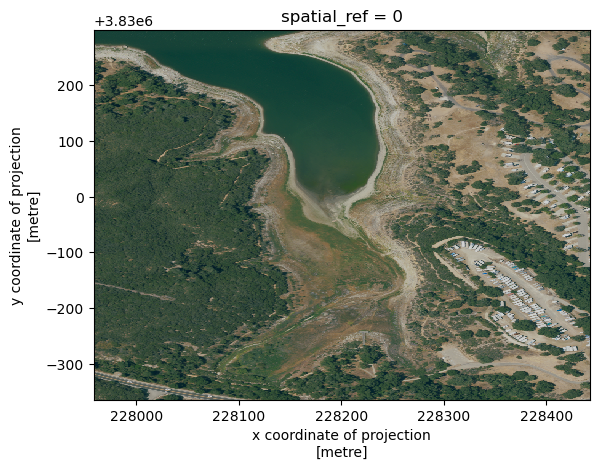

In [14]:
# Select the the first three bands of the NAIP dat
# Plot the first three bands
raster1_clip.sel(band=[1,2,3]).plot.imshow()

#### Stack Rasters

Our goal is to use the `gif` function to create a GIF with the four NAIP images over Lake Cachuma.

The `gif` documentation indicates that to do so we will need to put our images/rasters in a single `xarray.DataArray` with dimensions (time, band, y, x). Check your raster to see what the dimmensions are. Do they match the dimensions that the GIF function requires? 

In [15]:
# Check raster dimensions
print(raster1_clip.dims)

# Check the shape of the raster
print(raster1_clip.shape)

('band', 'y', 'x')
(4, 1105, 806)


To create a single `xarray.DataArray` with a time dimension we will stack the four rasters we obtained in our search. We use a for loop to repeat the previous steps for each item in the search (access the item’s image asset, clip, and select bands) and store each processed raster in a list `rasters`.

In [16]:
rasters = []
for item in items: 
    # Access the image asset
    lake_levels = rioxr.open_rasterio(item.assets['image'].href)
    
    # Clip the raster
    lake_levels = lake_levels.rio.clip_box(*box_df.to_crs(lake_levels.rio.crs).total_bounds)
    
    # Select the first three bands
    lake_levels = lake_levels.sel(band = [1, 2, 3])
    
    rasters.append(lake_levels)

Next let's use the `xarray.concat()` function to concatenate these rasters along a new dimensions we will call `time`. 

In [17]:
# Concatenate rasters into single xarray.DataArray
raster_stack = xr.concat(objs=rasters, dim='time')

Notice our new dimension `time` does not have any coordinates associated to it. To add coordinates to this dimensions we use the `assign_coords()`  method for `xarray.DataArray`.

It would be reasonable to use the year of collection of each raster (as a timestamp) as its coordinate on the time dimension. We can see this year in the item’s properties:

In [18]:
# Year of collection of an item 
item = items[0]
item.properties['naip:year']

'2022'

In [19]:
# Convert strings to datetime
pd.to_datetime(item.properties['naip:year'])

Timestamp('2022-01-01 00:00:00')

To get this timestamp for each year we can create a list using list comprehension:

**List comprehension format reminder:** `[expression for item in items if condition]`

Use this format  and the code above to add a timestamp for each year.

In [23]:
times = [pd.to_datetime(item.properties['naip:year']) for item in items]

And finally we assign these times as the coordinates (using `assign_coords()`) and sort by the vlaues of time dimension:



In [24]:
raster_stack = raster_stack.assign_coords(time=times).sortby("time")

#### Now its  time to make a GIF! 

Use [`gif()`](https://geogif.readthedocs.io/en/latest/api.html#local-gif) to create a GIF of our stacked raster.  Look at the documentation for `gif()`. What does the `fps` argument stand for? 


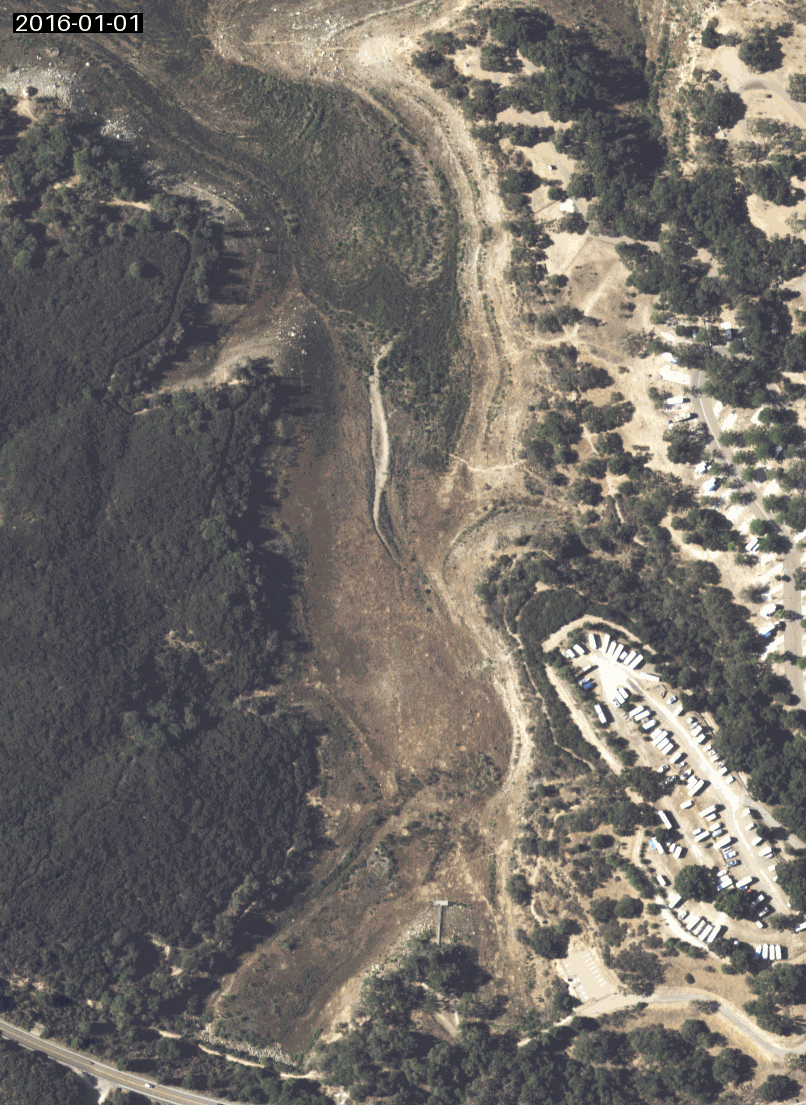

In [26]:
# Create GIF
gif(raster_stack, fps=0.8)

### References

Santa Maria Times. "Cachuma Lake Among the Last of State's Reservoirs in Exceptional Drought." Santa Maria Times. January 26, 2017. https://santamariatimes.com/news/local/cachuma-lake-among-the-last-of-states-reservoirs-in-exceptional-drought/article_e358ca8e-654d-5ff7-9b58-857914a4ccd4.html.

The Santa Barbara Independent. "Cachuma Fills and Flood Gates to Open." The Santa Barbara Independent, January 14, 2023. https://www.independent.com/2023/01/14/cachuma-fills-and-flood-gates-to-open/.